In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import os
import pandas as pd
from nilearn import datasets, plotting, input_data
from nilearn.image import index_img
from scipy.io import savemat, loadmat
from scipy.stats import zscore
import nibabel as nib

mode2plot = 1
CCA_path = "/home/leah/Git/BodyWanderingCCA/figures/CCA_BWitems/"  
CCA_filename = f'brainloadings.mat' 
savepath = f'/home/leah/Git/body_wandering/figures/CCA/Abend216/BWitems/'


/opt/anaconda3/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


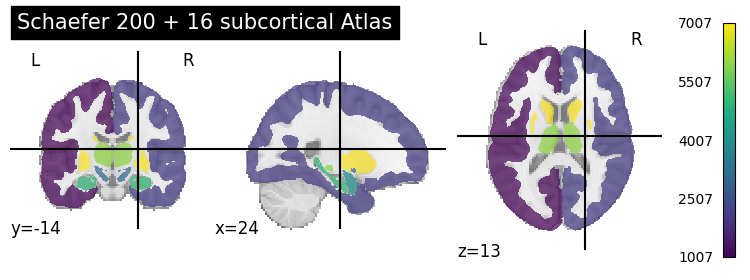

In [2]:
parcel_num = 200 # + 16 subcortical
combined_atlas = f"/mnt/fast_scratch/Atlases/atlas_abend{parcel_num}/atlas_schaefer{parcel_num}_7net_3d.nii.gz"

# Load the atlas image using nibabel
atlas_img = nib.load(combined_atlas)
# Plot the atlas
plotting.plot_roi(atlas_img, cmap='viridis', colorbar=True, title=f'Schaefer {parcel_num} + 16 subcortical Atlas')
plotting.show()

labels_coords = pd.read_csv('/mnt/fast_scratch/Atlases/atlas_abend200/abend216_mnicoords_AtlasLabels.csv')
labels_coords_short = pd.read_csv('~/Git/body_wandering/data/abend216_yeo7+InteroNetwork.csv')

# # Load the Schaefer atlas from Nilearn for comparison
# atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200)
# atlas_img = atlas.maps
# # Plot the Schaefer atlas
# plotting.plot_roi(atlas_img, cmap='viridis', colorbar=True, title='Schaefer Atlas')
# plotting.show()


In [4]:
# Load CCA results
cca_mat = loadmat(f"{CCA_path}{CCA_filename}") 
A = cca_mat["weightX"]


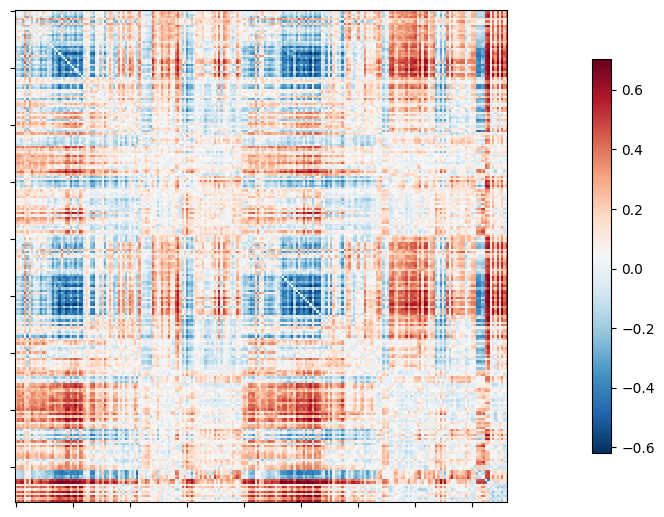

In [5]:
# Plot connectivity CCA loadings/weights
fmri_loadings = A
n_areas= 216
n_components = 1

# def plot_connectivity_matrix(fmri_loadings, n_areas, n_components):
lim = np.abs(fmri_loadings).max()

# Transform the flatten weights for network strength back to matrices for visualisation
idx = np.tril_indices(n_areas, k=-1)
corr_mat = np.zeros((n_areas, n_areas, n_components))
for i in range(n_components):
    this_mat = np.zeros((n_areas, n_areas))
    this_mat[idx] = fmri_loadings[:,i] 
    corr_mat[..., i] = this_mat + this_mat.T


plotting.plot_matrix(
    corr_mat[:, :,0])#, 
    # labels = labels_coords["labels"].tolist(),
    # reorder=True, figure=(10, 8),
    # vmax=lim, vmin=-lim)


In [6]:
# get yeo 7 network columns
labels_coords = labels_coords.copy() #Avoid SettingWithCopyWarning
labels_coords['yeo-7'] = labels_coords['labels'].str.split('-', n=2).str[1] #labels_coords['labels'].str.split('_').str[1].str.split('-').str[:2].str.join('-')
labels_coords['yeo-7'].iloc[-16:] = 'Subcortical'
labels_coords['yeo-7'].unique()

/tmp/ipykernel_527452/1545002307.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_coords['yeo-7'].iloc[-16:] = 'Subcortical'


array(['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont',
       'Default', 'Subcortical'], dtype=object)

In [7]:
# load yeo 7 networks with additional Interoceptive Network
labels_coords_intero = pd.read_csv('/home/leah/Git/body_wandering/data/abend216_yeo7+InteroNetwork.csv')
labels_coords['yeo-7'] = labels_coords_intero['yeo7Intero_Shortlabels']
labels_coords['yeo-7'].unique()

array(['Vis', 'SomMot', 'Intero', 'DorsAttn', 'SalVentAttn', 'Limbic',
       'Cont', 'Default', 'Subcortical'], dtype=object)

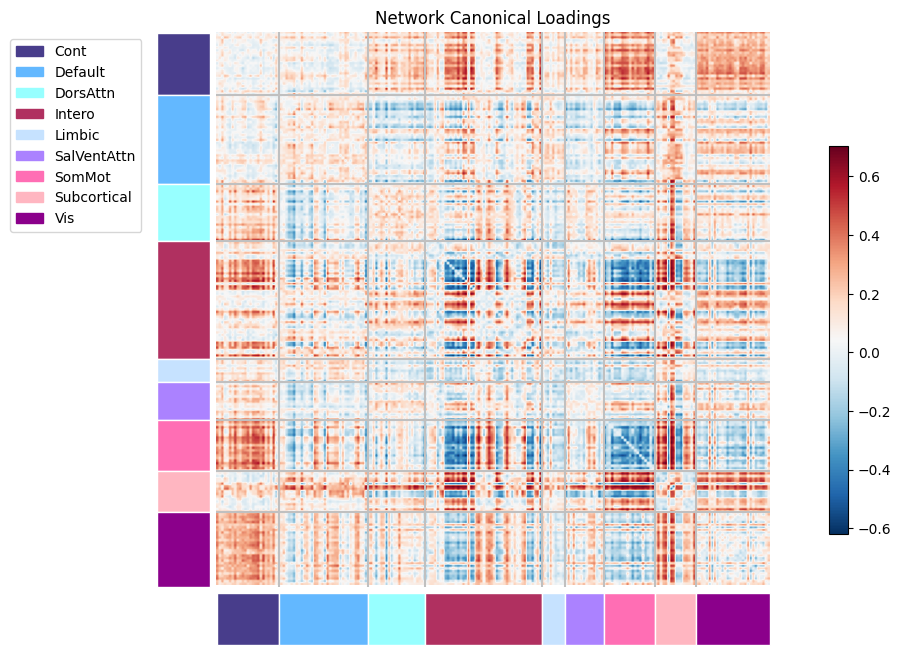

In [7]:
# Plot fmri CCA loadings/weights grouped by network - Abend Schaefer + 16 subcortical
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

fmri_loadings = A # connectivity canonical loadings/weights
n_areas= 216
n_components=1

lim = np.abs(fmri_loadings).max()

# Transform the flatten weights for network strength back to matrices for visualisation
idx = np.tril_indices(n_areas, k=-1)
corr_mat = np.zeros((n_areas, n_areas, n_components))
for i in range(n_components):
    this_mat = np.zeros((n_areas, n_areas))
    this_mat[idx] = fmri_loadings[:,i] 
    corr_mat[..., i] = this_mat + this_mat.T
        
# reorganise matrix according to network
reoder_idx = np.argsort(labels_coords["yeo-7"]) 
#corr_array.iloc[idx, :].T.iloc[idx, :]
corr_mat = corr_mat[reoder_idx, :][:, reoder_idx]

# get network labels
labels = np.unique(labels_coords["yeo-7"]) 
total_networks = np.unique(labels_coords["yeo-7"], return_counts=True)[1] 
# colors that match chordplot
colors = [
    (72,61,139),        # darkslateblue
    (99,184,255),      # steelblue1
    (151,255,255),      # darkslategray1
    (176,48,96),          # maroon
    (198,226,255),      # slategray1
    (171,130,255),      # mediumpurple
    (255,110,180),       # hotpink
    (255,182,193),      # lightpink
    (139,0,139)         #darkmagenta
]
# Normalize RGB values to range [0, 1]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# sort counts for regions in each network
counts_end = np.cumsum(total_networks)
counts_end = np.expand_dims(counts_end, axis = 1)
counts_start = counts_end[0:-1] #+1
counts_start = np.insert(counts_start, 0, 0)
counts_start = np.expand_dims(counts_start, axis = 1)
counts = np.append(counts_start, counts_end, axis=1)

# plot fmri loadings/weights
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_mat, cmap="RdBu_r")
# Remove the border around the heatmap
ax.spines[:].set_color('none')
ax.set_title('Network Canonical Loadings') #weights
#fig.colorbar(im)
fig.colorbar(im,fraction=0.025)

# create axes next to plot
divider = make_axes_locatable(ax)
axb = divider.append_axes("bottom", "10%", pad=0.06, sharex=ax)
axl = divider.append_axes("left", "10%", pad=0.06, sharey=ax)
axb.invert_yaxis()
axl.invert_xaxis()
axb.axis("off")
axl.axis("off")

# plot colored bar plots to the axes
barkw = dict(color=colors, linewidth=1, ec="white", clip_on=False, align='edge',)
axb.bar(counts[:,0],np.ones(len(labels)),  # labels needs to be indice points 
        width=total_networks, **barkw)
axl.barh(counts[:,0],np.ones(len(labels)), 
        height=total_networks, **barkw)

# set margins to zero again
ax.margins(0)
ax.tick_params(axis="both", bottom=0, left=0, labelbottom=0,labelleft=0)
    
# # Label the boxes - (if want labels in boxes)
# textkw = dict(ha="center", va="center", fontsize="small")
# idx = 0
# for k,l in counts:
#     axb.text((k+l)/2.,0.5, "{}".format(labels[idx]), **textkw)
#     axl.text(0.5,(k+l)/2., "{}".format(labels[idx]), rotation=-90,**textkw)
#     idx = idx + 1

# vertical lines to indicate network
# y min and max
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.vlines(x=[counts[1:,0]], ymin=ymin, ymax=ymax, colors=['silver'], ls='-', lw=1.5)
ax.hlines(y=[counts[1:,0]], xmin=xmin, xmax=xmax, colors=['silver'], linestyle='-', lw=1.5)

# add extra space for legend
axl_extra = divider.append_axes("left", "10%", pad=0.06, sharey=ax)
axl_extra.invert_xaxis()
axl_extra.axis("off")
# Creating legend with color box
pop = []
for count, color in enumerate(colors):
    pop.append(mpatches.Patch(color=color, label=labels[count]))
plt.legend(handles=pop)


#plt.savefig(f'{savepath}heatmap_CCAweights_brain_networks.png')
plt.savefig(f'{savepath}heatmap_CCAloadings_brain_networks_Intero.png')

plt.show()

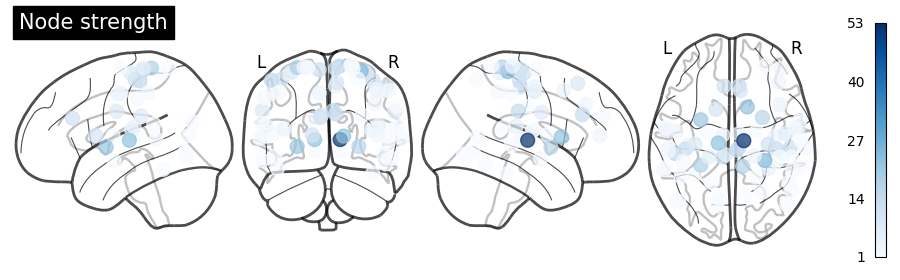

In [8]:
import numpy as np
import pandas as pd
from nilearn import plotting

fmri_loadings = A # connectivity canonical loadings/weights
n_areas= 216
n_components=1

lim = np.abs(fmri_loadings).max()

# Create corr_mat again as reordered based on network above
idx = np.tril_indices(n_areas, k=-1)
corr_mat = np.zeros((n_areas, n_areas, n_components))
for i in range(n_components):
    this_mat = np.zeros((n_areas, n_areas))
    this_mat[idx] = fmri_loadings[:,i] 
    corr_mat[..., i] = this_mat + this_mat.T

percentile = 99
threshold = np.percentile(np.abs(corr_mat[:, :, i]), percentile)

#mni_coords = list(labels_coords[['mnicoordsX', 'mnicoordsY', 'mnicoordsZ']].itertuples(index=False, name=None))

# make rounded combined mni coords col
labels_coords['combined_coords'] = labels_coords.apply(lambda row: (row['mnicoordsX'], row['mnicoordsY'], row['mnicoordsZ']), axis=1)
labels_coords['combined_coords'] = [tuple(round(coord, 0) for coord in item) for item in labels_coords['combined_coords']]

# Convert string coordinates to a NumPy array
sum_of_connections = (np.abs(corr_mat[:, :, i]) > threshold).sum(axis=1)

n_connections = 0 #np.percentile(np.abs(sum_of_connections), percentile) # threshold for sums (only plots if sums are above this)    # 0

this_coordinates = np.array(list(labels_coords['combined_coords'][sum_of_connections > n_connections]))
this_sum = sum_of_connections[sum_of_connections > n_connections]

plotting.plot_markers(
    node_coords=this_coordinates,
    node_values=this_sum,
    title=f"Node strength",
    node_cmap="Blues",
    display_mode="lyrz"
)

In [10]:
# 99% threshold for chordplot
np.percentile(np.abs(corr_mat[:, :, i]), 99)
threshold

0.5583126506119361

In [10]:
# top labels
sorted_indices = np.array(np.argsort(sum_of_connections[sum_of_connections > n_connections])[::-1])

print(labels_coords['labels'][sum_of_connections>n_connections].iloc[sorted_indices])
# top node sums
print(sum_of_connections[sum_of_connections>n_connections][sorted_indices])
# top parcel numbers
print(labels_coords['parcelnum'][sum_of_connections>n_connections].iloc[sorted_indices])

with open(f'{savepath}brainloading_thresh{np.round(threshold,3)}_sumthresh{np.round(n_connections,3)}_{percentile}percentile.txt', 'w') as file:
    for label, node_sum in zip(labels_coords['labels'][sum_of_connections > n_connections].iloc[sorted_indices], sum_of_connections[sum_of_connections > n_connections][sorted_indices]):
        file.write(f"{label}: {node_sum}\n")


207                             Thalamus_R
129               Schaefer_Right-SomMot-15
206                             Thalamus_L
213                 Striatum_Right-Caudate
211                  Striatum_Left-Putamen
                      ...                 
103                   Schaefer_Right-Vis-4
100                   Schaefer_Right-Vis-1
75            Schaefer_Left-Default-Temp-3
43     Schaefer_Left-SalVentAttn-ParOper-1
2                      Schaefer_Left-Vis-3
Name: labels, Length: 71, dtype: object
[53 24 22 22 21 18 17 16 15 14 13 13 12 12 12 11 11 11 10  9  8  8  7  7
  7  6  5  5  4  4  4  4  4  4  4  3  3  3  2  2  2  2  2  2  2  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
207    6001
129    2030
206    6000
213    7005
211    7003
       ... 
103    2004
100    2001
75     1076
43     1044
2      1003
Name: parcelnum, Length: 71, dtype: int64


In [11]:
sorted_indices = np.array(np.argsort(sum_of_connections[sum_of_connections > n_connections])[::-1])

# top labels 
print(labels_coords_short['short_labels'][sum_of_connections>n_connections].iloc[sorted_indices])
# top node sums
print(sum_of_connections[sum_of_connections>n_connections][sorted_indices])

with open(f'{savepath}brainloading_thresh{np.round(threshold,3)}_sumthresh{np.round(n_connections,3)}_{percentile}percentile_shortlabels.txt', 'w') as file:
    for label, network, node_sum in zip(labels_coords_short['short_labels'][sum_of_connections > n_connections].iloc[sorted_indices], labels_coords_short["yeo7Intero_Shortlabels"][sum_of_connections > n_connections].iloc[sorted_indices], sum_of_connections[sum_of_connections > n_connections][sorted_indices]):
        file.write(f"{label} - {network}: {node_sum}\n")


207                         Thalamus R
129                Postcentral Gyrus R
206                         Thalamus L
213                          Caudate R
211                          Putamen L
                    ...               
103                    Lingual Gyrus R
100    Temporal Fusiform Cortex Post R
75       Superior Temporal Gyrus Ant L
43                  Planum Temporale L
2       Lateral Occipital Cortex Inf L
Name: short_labels, Length: 71, dtype: object
[53 24 22 22 21 18 17 16 15 14 13 13 12 12 12 11 11 11 10  9  8  8  7  7
  7  6  5  5  4  4  4  4  4  4  4  3  3  3  2  2  2  2  2  2  2  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


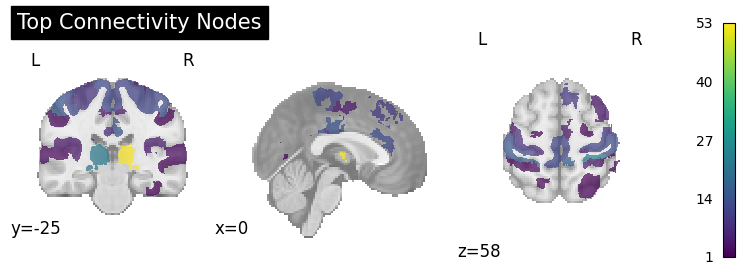

In [17]:
import nibabel as nib
import numpy as np
from nilearn import plotting

# Get the selected parcel numbers
selected_parcels = labels_coords.loc[sum_of_connections > n_connections, 'parcelnum'].tolist() # numbers of parcels

# Create a binary mask for the selected parcels
parcel_data = atlas_img.get_fdata()
parcel_mask = np.zeros_like(parcel_data, dtype=float) # all zero

# Get the sums corresponding to the selected parcels
selected_parcel_sums = sum_of_connections[sum_of_connections > n_connections]
    
# Assign the sums to the selected parcel locations in the mask
for parcel_num, sum_value in zip(selected_parcels, selected_parcel_sums):
    parcel_mask[parcel_data == parcel_num] = sum_value

# save as nifti for plotting mricrogl    
nifti_image = nib.Nifti1Image(parcel_mask.astype(int), atlas_img.affine)
nib.save(nifti_image, f'{savepath}Brainloadings_thresh{np.round(threshold,3)}_sumthresh{np.round(n_connections,3)}_{percentile}percentile.nii.gz')

# Plot the selected parcels using nilearn
plotting.plot_roi(nifti_image, cmap='viridis', colorbar=True, title='Top Connectivity Nodes', draw_cross = False)
#plotting.show()

plt.savefig(f'{savepath}Brainloadings_thresh{np.round(threshold,3)}_sumthresh{np.round(n_connections,3)}_{percentile}percentile.png')  

In [10]:
import pandas as pd
import scipy.io

# Load weightY from a MATLAB .mat file
mat_data = scipy.io.loadmat(f'{CCA_path}psychloadings.mat')
weightY = mat_data['weightY'].flatten()  # Assuming 'weightY' is the variable name in the .mat file

# Labels
labels = ['Future', 'Past', 'Self', 'Other', 'Pos', 'Neg', 'Words', 'Vivid', 'Vague', 'Focus', 'Ruminate', 'Distant', 'Image', 'Arousal', 'Body', 'Breath', 'Heart', 'Movement', 'Bladder', 'Skin', 'Stomach']

# Create a DataFrame and sort by absolute values
df = pd.DataFrame({'Label': labels, 'WeightY': weightY})
df['WeightY_Abs'] = df['WeightY'].abs()  # Add a column for absolute values
df_sorted = df.sort_values(by='WeightY_Abs', ascending=False)

# Save the result as a CSV file
np.round(df_sorted[['Label', 'WeightY']],3).to_csv(f'{savepath}sorted_weightY.csv', index=False)